In [316]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
from PIL import Image
import os
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [299]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [2]:
data_dir = ''


In [302]:
# Verification of the number of Images 

# load filenames for human and dog images
dataset = np.array(glob(data_dir+"images/*"))
# print number of images in each dataset
print('There are %d total images.' % len(dataset))

sample_csv = pd.read_csv(data_dir + 'sample_submission.csv')
test_csv = pd.read_csv(data_dir + 'test.csv')
train_csv = pd.read_csv(data_dir + 'train.csv')

test_csv


There are 3642 total images.


,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4
...,...
1816,Test_1816
1817,Test_1817
1818,Test_1818
1819,Test_1819


In [286]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        self.target    = target_col
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for test
        if self.transform is not None:
            image = self.transform(image)
        
        # define the label based on the idx
        label = self.data.iloc[idx, 1:5].values.astype('int64')
        label = np.argwhere(label ==1)
        label = label.item(0)
        label = torch.tensor(label)
        
        return image, label

In [287]:
plok = pd.read_csv(data_dir+'train.csv').iloc[3, 1:5].values.astype('int64')
print(type(plok))
print(plok)

plok2 = np.argwhere(plok ==1)
print(type(plok2))
print(plok2)
inter = plok2.item(0)
print(inter)
print(type(inter))
inter_2 = torch.tensor([inter])
print(inter_2)
print(type(inter_2))
lable_plok = torch.from_numpy(plok2)
print(lable_plok)

<class 'numpy.ndarray'>
[0 0 1 0]
<class 'numpy.ndarray'>
[[2]]
2
<class 'int'>
tensor([2])
<class 'torch.Tensor'>
tensor([[2]])


In [303]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

params = {
    'id_col':     'image_id',  
    'target_col': ['healthy', 'multiple_diseases', 'rust', 'scab'],
    'sufix':      '.jpg',
    'transform':  data_transforms['train']
}

train_dataset = CustomDataset(csv_file=data_dir+'train.csv', root_dir=data_dir+'images', **params)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

print('TRAINING')
img, lab = train_dataset.__getitem__(0)

print('DATASET')
print('image at the first row: {}', img.shape)
print('image size at the first row: {}'.format(img.size()))
print('Lab at the first row: {}', type(lab))
print('lab format at the first row: {}'.format(lab))


print()
print('Train Loader type')
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()
print()
print('DATALOADER')
print('images type on batch size = {}'.format(type(images)))
print('images shape on batch size = {}', images.shape)
print('labels type on batch size = {}'.format(type(labels)))
print('labels shape on batch size = {}', labels.shape)



TRAINING
DATASET
image at the first row: {} torch.Size([3, 224, 224])
image size at the first row: torch.Size([3, 224, 224])
Lab at the first row: {} <class 'torch.Tensor'>
lab format at the first row: 3

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER
images type on batch size = <class 'torch.Tensor'>
images shape on batch size = {} torch.Size([4, 3, 224, 224])
labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size = {} torch.Size([4])


In [289]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # CL sees 224 x 224 x 3 image tensor
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # CL sees 112 x 112 x 16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # CL sees 56 x 56 x 32
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 28 * 28 -> 500)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 4)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        ## Define forward behavior       
        x = self.pool(F.relu(self.conv1(x)))      
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))       
        # flatten image input
        x = x.view(-1, 64 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # output layer layer, with sigmoid activation function
        x = F.sigmoid(self.fc2(x))
        return x
    
    
model_patho = Net()
model_patho

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [290]:
### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = optim.SGD(model_patho.parameters(), lr=0.001)

In [335]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target) in enumerate(loaders):

            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            
            #target = target.squeeze(-1)
            #print(target.shape)
            
            #print('\nIndex\n', idx) 
            #print('\n DATA \n', data)
            #print('n', data.shape)
            #print('\n OUTPUT \n', output)
            #print('n', output.shape)
            #print('\n TARGET \n', target)
            #print('n', target.shape)
        
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            #update training loss
            train_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders.sampler)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            torch.save(model_patho.state_dict(), 'model_patho.pt')
            ))
            
    # return trained model
    return model


In [ ]:
model_res = train(10, train_loader, model_patho, optimizer, criterion)

# load the model that got the best validation accuracy
model_res.load_state_dict(torch.load('model_patho.pt'))

Epoch: 1 	Training Loss: 1.269125
Epoch: 2 	Training Loss: 1.266718


In [308]:
model_res

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

# Test

In [ ]:
test_img = Image.open(open("images/Test_3.jpg", 'rb'))

test_img = data_transforms['test'](test_img)

test_img.shape

#res = model_res(test_img)

#res

In [324]:
class CustomDataset_test(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        self.target    = target_col
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for test
        if self.transform is not None:
            image = self.transform(image)
        
        return image

data_transforms_test = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

params = {
    'id_col':     'image_id',  
    'target_col': ['healthy', 'multiple_diseases', 'rust', 'scab'],
    'sufix':      '.jpg',
    'transform':  data_transforms['test']
}

test_dataset = CustomDataset_test(csv_file=data_dir+'test.csv', root_dir=data_dir+'images', **params)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

print('TRAINING')
img = test_dataset.__getitem__(0)

print('DATASET TEST')
print('image at the first row: {}', img.shape)
print('image size at the first row: {}'.format(img.size()))

print()
print('Train Loader type')
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()
print()
print('DATALOADER')
print('images type on batch size = {}'.format(type(images)))
print('images shape on batch size = {}', images.shape)
print('labels type on batch size = {}'.format(type(labels)))
print('labels shape on batch size = {}', labels.shape)


TRAINING
DATASET TEST
image at the first row: {} torch.Size([3, 224, 224])
image size at the first row: torch.Size([3, 224, 224])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER
images type on batch size = <class 'torch.Tensor'>
images shape on batch size = {} torch.Size([4, 3, 224, 224])
labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size = {} torch.Size([4])


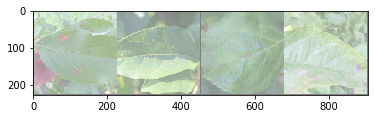

In [328]:
classes = ('healthy', 'multiple_diseases', 'rust', 'scab')

dataiter = iter(test_loader)
images = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

## Submission

In [311]:
submission_df = pd.read_csv(data_dir + 'sample_submission.csv')
submission_df.iloc[:, 1:] = 0

submission_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0,0,0,0
1,Test_1,0,0,0,0
2,Test_2,0,0,0,0
3,Test_3,0,0,0,0
4,Test_4,0,0,0,0
